In [1]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml

MAX_JETS = 6
PLOTS_DIR = f"plots/feature_plots/"
CONFIG_PATH = "../config/workspace_config.yaml"

import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
plt.rcParams.update({"font.size": 14})

load_config = get_load_config_from_yaml(CONFIG_PATH)

DataProcessor = DataPreprocessor(load_config)

with open(CONFIG_PATH, "r") as file:
    load_config = yaml.safe_load(file)


data_config = DataProcessor.load_from_npz(load_config["npz_datapath"]["nominal"], max_events=100000)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.99)

2025-11-20 09:21:31.043255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763626891.066691 2701819 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763626891.074605 2701819 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763626891.092993 2701819 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763626891.093018 2701819 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763626891.093020 2701819 computation_placer.cc:177] computation placer alr

In [2]:
import core.assignment_models as AssignmentModels
import core.reconstruction as Evaluation

reload(Evaluation)
reload(AssignmentModels)
evaluator = Evaluation.ReconstructionEvaluator(
    [
        AssignmentModels.DeltaRAssigner(config=data_config),
        AssignmentModels.ChiSquareAssigner(config=data_config),
        #AssignmentModels.ChiSquareAssigner(config=data_config,use_nu_flows_for_assignment=False),
        Evaluation.GroundTruthReconstructor(config=data_config,name="Perfect Reconstruction"),
    ],
    X_val,
    y_val,
)


Computing bootstrap confidence intervals...
$\Delta R(\ell,j)$-Assigner: 0.4762 [0.4731, 0.4795]
$\chi^2$-Method ($\nu^2$-Flows): 0.6086 [0.6056, 0.6113]
Perfect Reconstruction: Ground Truth (skipping)


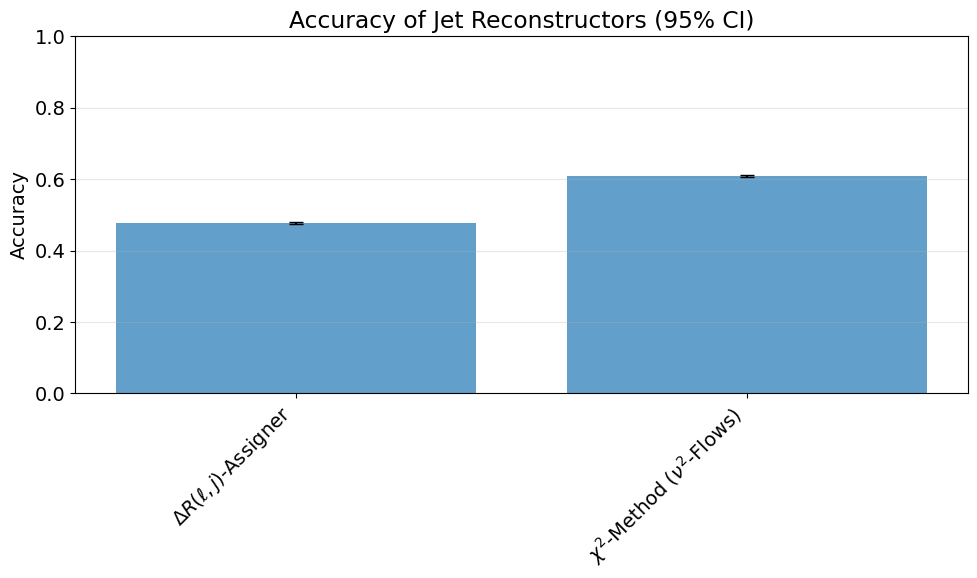

In [3]:
fig, ax = evaluator.plot_all_accuracies()
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing binned top mass resolution for truth_ttbar_mass...


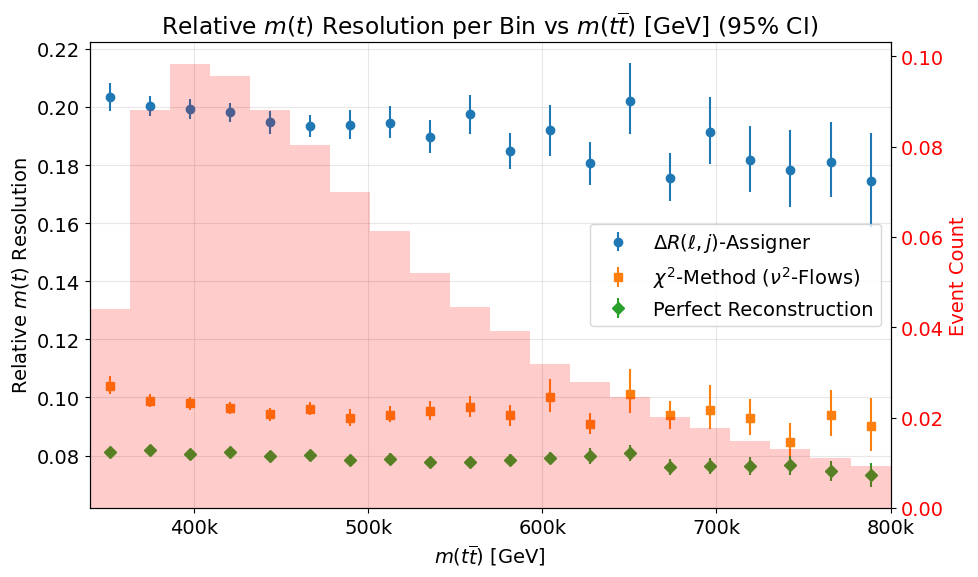

In [4]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}k" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")


Computing binned ttbar mass resolution for truth_ttbar_mass...


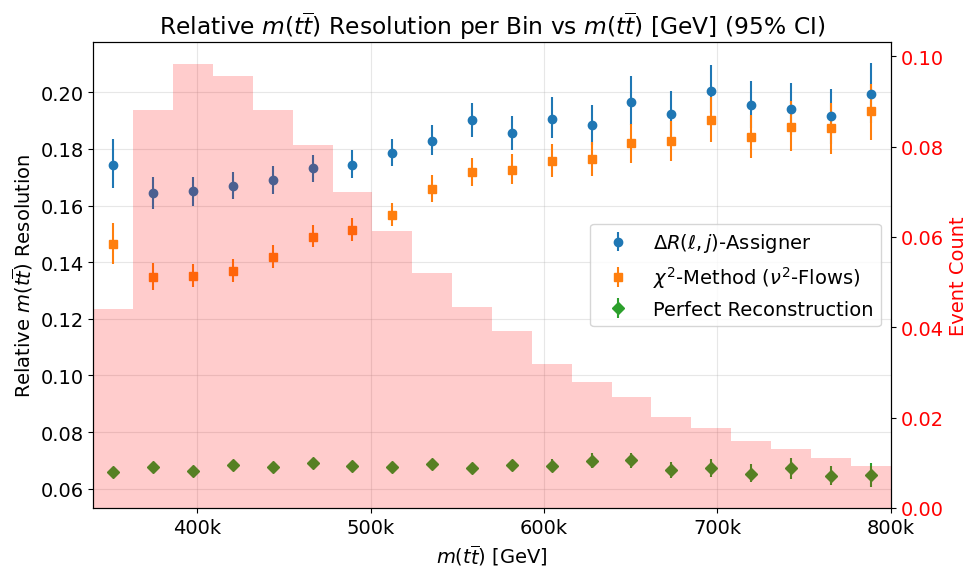

In [5]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}k" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing binned accuracy for truth_ttbar_mass...


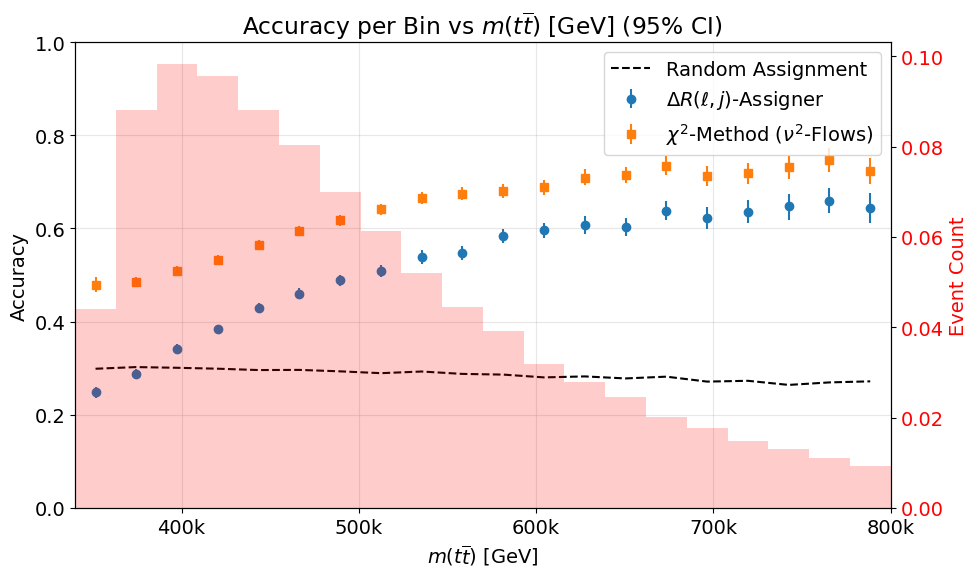

In [6]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}k" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_Hmmmass.pdf")


Computing binned accuracy for truth_ttbar_pt...


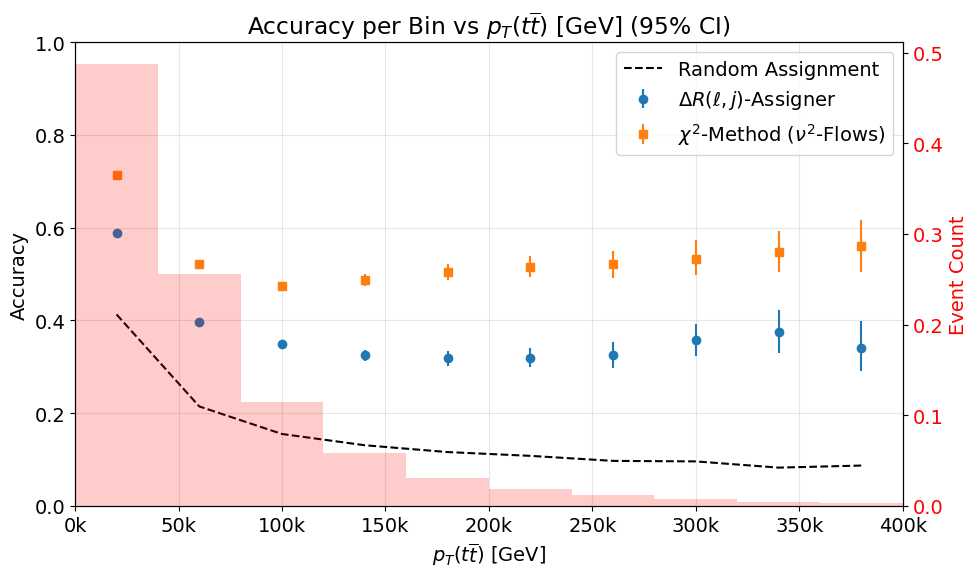

In [7]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}k" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


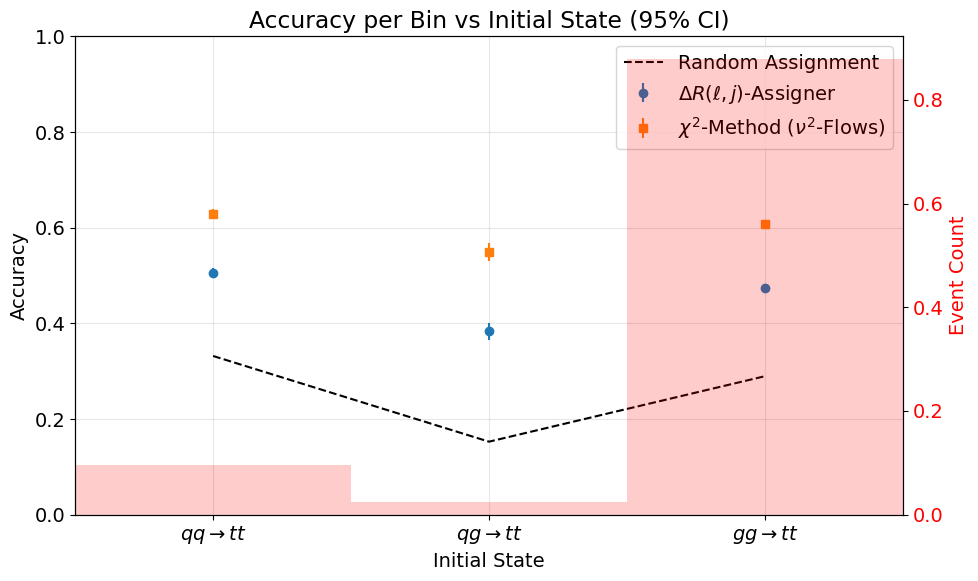

In [8]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")


Computing binned accuracy for N_jets...


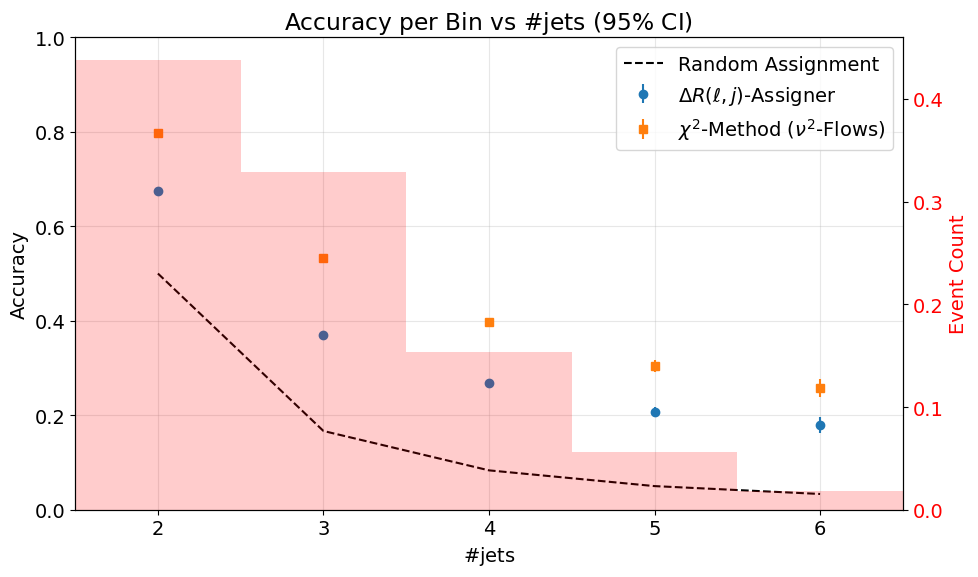

In [9]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, MAX_JETS + 1),
    bins= MAX_JETS -1,
)
ax.set_xticks([i + 0.5 for i in range(2, MAX_JETS + 1)])
ax.set_xticklabels([i for i in range(2, MAX_JETS + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

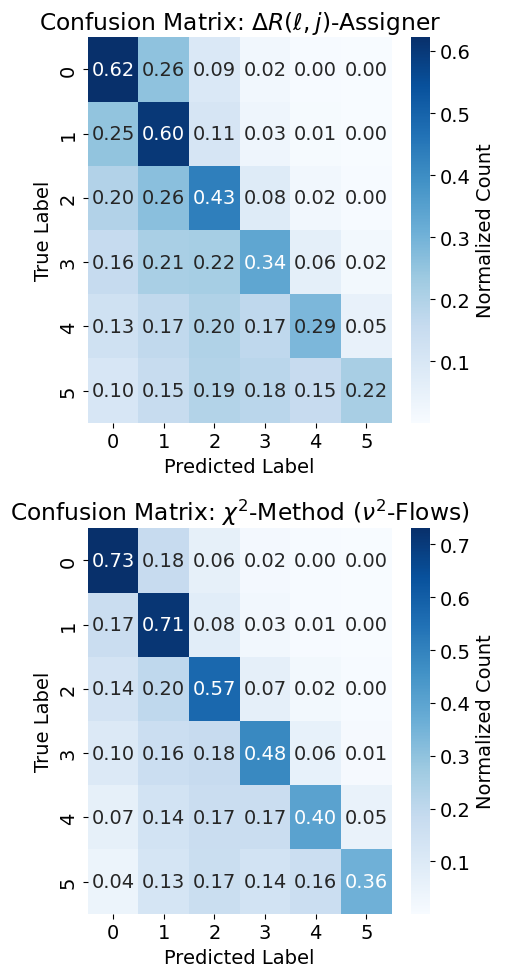

In [10]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

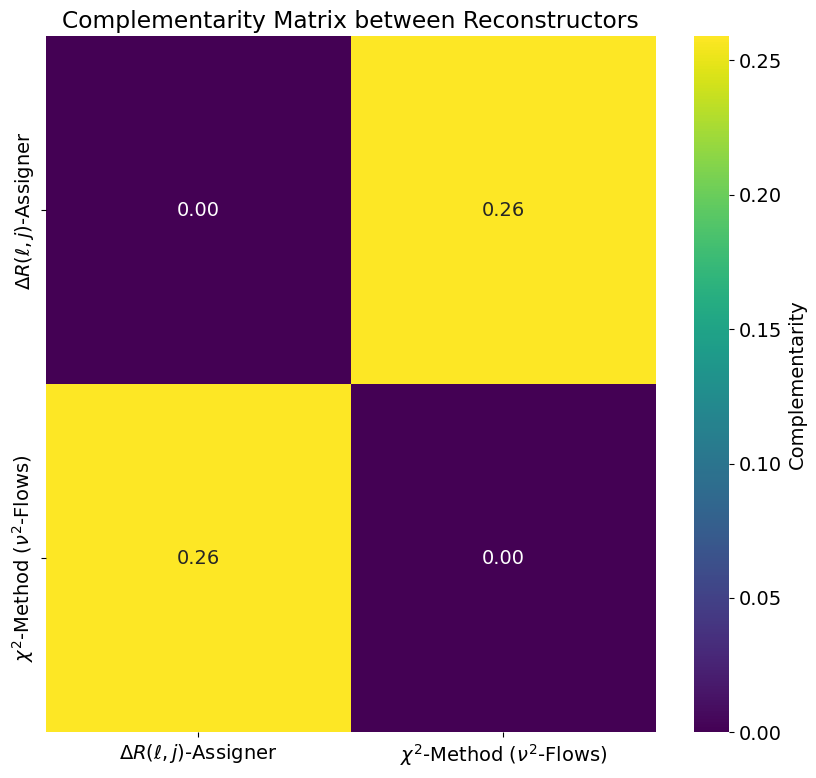

In [11]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(8.5, 8))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")